# Clasificación de rostros por grupo etario

In [1]:
import numpy as np
import torch as th
import math
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import PIL
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as T
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

Constantes generales del programa.

In [2]:
SEMILLA = 150
th.manual_seed(SEMILLA)
np.random.seed(SEMILLA)
T_LOTE = 64
T_IMAGEN_RESIZED = (64, 64) # posible cambio
N_EPOCAS = 50 # cambiar
LOGDIR = './logs/'
DC = 'cuda:0' if th.cuda.is_available() else 'cpu'

Se clona el conjunto de datos de github.

In [3]:
# Comentar si ya esta clonado, descomentar si no esta clonado
# !git clone https://github.com/epeto/fairface.git

Se construyen diccionarios que relacionen una categoría en string con una categoría en entero.

In [4]:
def extract_num(cadena):
    salida = cadena[-1]
    if cadena[-2].isdigit():
        salida = cadena[-2] + salida
    return int(salida)

# Construye dos diccionarios para una lista de categorías
def build_dict(cats):
    cats = list(np.unique(cats))
    cats.sort(key=extract_num)
    str_a_ind = {} # cadena a índice
    ind_a_str = {} # índice a cadena
    for i,s in enumerate(cats):
        str_a_ind[s] = i
        ind_a_str[i] = s
    return str_a_ind, ind_a_str

datos_csv = pd.read_csv('fairface/fairface_label_train.csv')
str_a_ind, ind_a_str = build_dict(datos_csv['age'].to_numpy())
n_clases = len(str_a_ind)
print(str_a_ind)
print(ind_a_str)
print('Número de clases:', n_clases)

{'0-2': 0, '3-9': 1, '10-19': 2, '20-29': 3, '30-39': 4, '40-49': 5, '50-59': 6, '60-69': 7, 'more than 70': 8}
{0: '0-2', 1: '3-9', 2: '10-19', 3: '20-29', 4: '30-39', 5: '40-49', 6: '50-59', 7: '60-69', 8: 'more than 70'}
Número de clases: 9


In [5]:
# construye el dataset a partir del csv
def build_dataset(dataset_csv, diccionario):
    X = dataset_csv['file']
    edades = dataset_csv['age']
    y = [diccionario[rango] for rango in edades]
    X = np.array(list(map(lambda s : 'fairface/'+s, X)))
    y = np.array(y)
    return X, y

Observamos los primeros 10 datos del conjunto de entrenamiento.

In [6]:
X_ent, y_ent = build_dataset(datos_csv, str_a_ind)
print(X_ent[:10])
print(y_ent[:10])

['fairface/train/1.jpg' 'fairface/train/2.jpg' 'fairface/train/3.jpg'
 'fairface/train/4.jpg' 'fairface/train/5.jpg' 'fairface/train/6.jpg'
 'fairface/train/7.jpg' 'fairface/train/8.jpg' 'fairface/train/9.jpg'
 'fairface/train/10.jpg']
[6 4 1 3 3 3 5 4 2 4]


Se subdivide el conjunto de entrenamiento en entrenamiento y validación.

In [7]:
# la estratificación se realiza por default con el conjunto de etiquetas (y_ent)
X_ent, X_val, y_ent, y_val = train_test_split(X_ent, y_ent, test_size=0.2, random_state=SEMILLA, shuffle=True)

Se aplica el mismo preprocesamiento al conjunto de prueba.

In [8]:
X_pru, y_pru = build_dataset(pd.read_csv('fairface/fairface_label_val.csv'), str_a_ind)

## Carga de datos

In [9]:
class Fairface(Dataset):
    def __init__(self, imagenes, categorias, transform=None):
        self.imagenes = imagenes
        self.categorias = categorias
        self.transform = transform

    def __getitem__(self, idx):
        img = PIL.Image.open(self.imagenes[idx])
        cat = self.categorias[idx]

        if self.transform:
            img = self.transform(img)

        return img, cat

    def __len__(self):
        return len(self.imagenes)

ds_ent = Fairface(X_ent, y_ent)

Observamos una imagen

Imagen = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1FB1B3CD8D0>
Categoría = 4
Etiqueta = 30-39


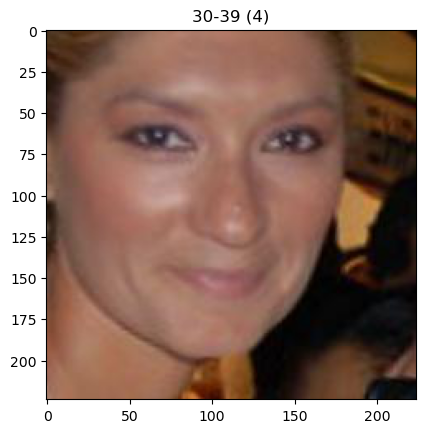

In [10]:
it_ent = iter(ds_ent)
par_ent = next(it_ent)
print('Imagen =',par_ent[0])
print('Categoría =', par_ent[1])
print('Etiqueta =', ind_a_str[par_ent[1]])

plt.imshow(par_ent[0])
cat_ej = par_ent[1]
plt.title(f'{ind_a_str[cat_ej]} ({cat_ej})')
plt.show()

Se crean las mismas clases para los conjuntos de validación y prueba.

In [11]:
ds_val = Fairface(X_val, y_val)
ds_pru = Fairface(X_pru, y_pru)

## Acrecentamiento de datos

Se definen las funciones de transformación para los conjuntos de entrenamiento, validación y prueba.

* Para entrenamiento se usará una composición de: `RandomCrop`, `Pad`, `RandomPerspective` y `Resize`.
* Para validación y prueba sólo se hará un `Resize`.

Al final se aplica `T.ToImage()` seguido de `T.ToDtype(torch.float32, scale=True)`, para cambiar de imagen de Pillow a un tensor de PyTorch.

In [12]:
CROP_SIZE = (170, 170)
# v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
transform_ent = T.Compose([T.RandomCrop(CROP_SIZE),
                           T.Pad(padding=20),
                           T.RandomPerspective(distortion_scale=0.3),
                           T.Resize(T_IMAGEN_RESIZED, antialias=True),
                           T.ToImage(),
                           T.ToDtype(torch.float32, scale=True)])
                           #T.ToTensor()])

transform_val = T.Compose([T.Resize(T_IMAGEN_RESIZED, antialias=True),
                           T.ToImage(),
                           T.ToDtype(torch.float32, scale=True)])
                           #T.ToTensor()])

transform_pru = T.Compose([T.Resize(T_IMAGEN_RESIZED, antialias=True),
                           T.ToImage(),
                           T.ToDtype(torch.float32, scale=True)])
                           #T.ToTensor()])

# Se agrega cada función a su respectivo atributo de objeto
ds_ent.transform = transform_ent
ds_val.transform = transform_val
ds_pru.transform = transform_pru

## Carga de datos por lotes

Se crea el cargador de datos para el conjunto de entrenamiento.

In [13]:
# muestra un lote de imágenes
def muestra_imagenes(imgs, etiq):
    t_muestra = imgs.shape[0]
    n_filas = n_cols = int(math.sqrt(t_muestra))
    fig, ax = plt.subplots(nrows=n_filas, ncols=n_cols, figsize=(2*n_filas, 2*n_cols))

    for i in range(n_filas):
        for j in range(n_cols):
            idx = i*n_filas + j
            ax[i,j].imshow(imgs[idx])
            ax[i,j].axis('off')
            ax[i,j].set_title(etiq[idx])
    plt.tight_layout()
    plt.show()

In [14]:
dataloader_ent = DataLoader(ds_ent, batch_size=T_LOTE, shuffle=True)
it_entdl = iter(dataloader_ent)
lote_ejemplo = next(it_entdl)
print('Imágenes =', lote_ejemplo[0].shape)
print('Categorías =', lote_ejemplo[1].shape)

Imágenes = torch.Size([64, 3, 64, 64])
Categorías = torch.Size([64])


Se visualiza un subconjunto de 9 imágenes del lote.

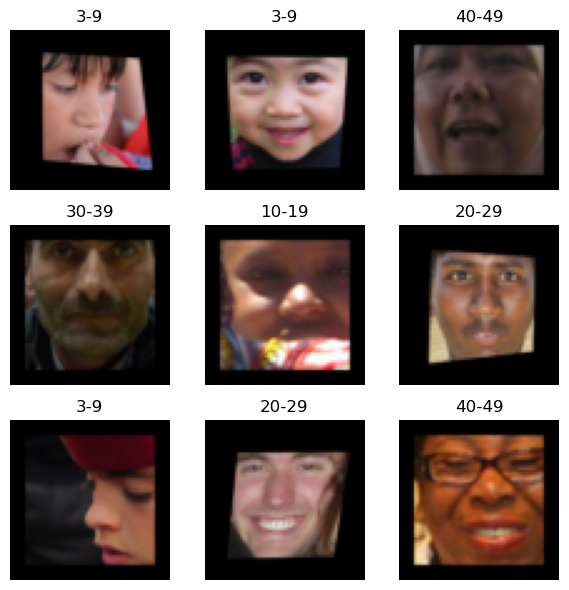

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [15]:
imgs = lote_ejemplo[0][:9]
etiqs = [ind_a_str[c] for c in lote_ejemplo[1][:9].numpy()]
muestra_imagenes(imgs.permute(0,2,3,1).numpy(), etiqs)
print(lote_ejemplo[0][0])

Se crean los cargadores para los conjuntos de validación y prueba.

In [16]:
dataloader_val = DataLoader(ds_val, batch_size=T_LOTE, shuffle=True)
dataloader_pru = DataLoader(ds_pru, batch_size=1, shuffle=True)

## Red neuronal y fase de entrenamiento

Primero se definen todas las funciones necesarias para el entrenamiento.

In [17]:
# Podemos guardar el estado del entrenamiento y de un modelo mediante la función save
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  th.save(estado_modelo, ckptpath)

In [18]:
#from torch.utils.tensorboard import SummaryWriter
def registra_info_tboard(writer, epoca, hist):
    for (m,v) in hist.items():
        writer.add_scalar(m, v[epoca], epoca)

In [19]:
def exactitud(y_hat, y):
    cmp = y_hat.argmax(dim=-1) == y
    aciertos = th.count_nonzero(cmp)
    return aciertos / cmp.shape[0]

In [20]:
def paso_ent(modelo, fp, metrica, opt, X, y):
    opt.zero_grad() # se ponen los gradientes asociados a los parámetros a actualizar en cero
    y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
    perdida = fp(y_hat, y) # se calcula la pérdida
    perdida.backward() # se obtienen los gradientes
    opt.step() # se actualizan todos los parámetros del modelo

    with th.no_grad():
        perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
        metricas_paso = metrica(y_hat, y)

    return perdida_paso, metricas_paso

In [29]:
import copy

def entrena(modelo, fp, metrica, opt, entdl, valdl, disp, ckptpath, n_epocas = 10, tbdir = 'runs/'):
    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)

    hist = {'perdida_ent':np.zeros(n_epocas),
            'perdida_val': np.zeros(n_epocas),
            metrica.__name__ + '_ent': np.zeros(n_epocas),
            metrica.__name__ + '_val': np.zeros(n_epocas)}

    tbwriter = SummaryWriter(tbdir)
    perdida_min = th.inf
    mejor_modelo = copy.deepcopy(modelo)
    for e in range(n_epocas):
        # bucle de entrenamiento
        modelo.train()
        for p, (Xlote,ylote) in enumerate(entdl):
            Xlote = Xlote.to(disp)
            ylote = ylote.type(torch.LongTensor) # linea agregada
            ylote = ylote.to(disp)
            perdida_paso, metrica_paso = paso_ent(modelo, fp, metrica, opt, Xlote, ylote)
            hist['perdida_ent'][e] += perdida_paso
            hist[metrica.__name__ + '_ent'][e] += metrica_paso

        # bucle de validación
        modelo.eval()
        with th.no_grad():
            for Xlote,ylote in valdl:
                Xlote = Xlote.to(disp)
                ylote = ylote.type(torch.LongTensor) # linea agregada
                ylote = ylote.to(disp)
                y_hat = modelo(Xlote)
                hist['perdida_val'][e] += fp(y_hat, ylote)
                hist[metrica.__name__ + '_val'][e] += metrica(y_hat, ylote)

        hist['perdida_ent'][e] /=  n_lotes_ent
        hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
        hist['perdida_val'][e] /=  n_lotes_val
        hist[metrica.__name__ + '_val'][e] /= n_lotes_val
        # guardamos checkpoint y copiamos pesos y sesgos del modelo actual si disminuye la metrica a monitorear
        if hist['perdida_val'][e] < perdida_min:
            mejor_modelo.load_state_dict(modelo.state_dict())
            guarda_ckpt(ckptpath, modelo, e, opt)

        registra_info_tboard(tbwriter, e, hist)
        print(f'\nÉpoca {e}: Perdida(E) = {hist["perdida_ent"][e]:.3f}, {metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, Perdida(V) = {hist["perdida_val"][e]:.3f}, {metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')
    return modelo, mejor_modelo, hist

### Construcción de la red neuronal

Bloque de ConvNext

In [22]:
class Conv(nn.Module):
    def __init__(self, cent, csal):
        super(Conv, self).__init__()
        # depthwise convolution: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        self.conv1 = nn.Conv2d(cent, cent, kernel_size=7, padding='same', groups=cent)
        self.conv2 = nn.Conv2d(cent, cent*4, kernel_size=1, padding='same')
        self.conv3 = nn.Conv2d(cent*4, csal, kernel_size=1, padding='same')
        if cent != csal:
            self.conv1x1 = nn.Conv2d(cent, csal, kernel_size=1)
        else:
            self.conv1x1 = None

    def forward(self, x):
        y = self.conv1(x)
        y = torch.permute(y, (0, 2, 3, 1))
        y = nn.functional.layer_norm(y, normalized_shape = y.shape)
        y = torch.permute(y, (0, 3, 1, 2))
        y = self.conv2(y)
        y = nn.functional.gelu(y)
        y = self.conv3(y)
        if self.conv1x1:
            x = self.conv1x1(x)
        return x+y

Se prueba el bloque con el lote de ejemplo.

In [23]:
conv_test = Conv(lote_ejemplo[0].shape[1], 10)
y_conv_test = conv_test(lote_ejemplo[0])
print('Shape input:', lote_ejemplo[0].shape)
print('Shape output:', y_conv_test.shape)

Shape input: torch.Size([64, 3, 64, 64])
Shape output: torch.Size([64, 10, 64, 64])


In [24]:
class BloqueConvNext(nn.Module):
  def __init__(self, cent, csal, k = 2):
    super(BloqueConvNext, self).__init__()

    self.res = [Conv(cent, csal)]
    for i in range(1, k):
      self.res.append(Conv(csal, csal))
    self.res = nn.ModuleList(self.res)

  def forward(self, x):
    for r in self.res:
      x = r(x)
    return x

In [25]:
class ConvNext18(nn.Module):
  def __init__(self,
               n_clases):
    super(ConvNext18, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2)
    self.mp1 = nn.MaxPool2d(kernel_size = 3, stride = 2)

    self.b1 = BloqueConvNext(64, 64, 2)
    self.b2 = BloqueConvNext(64, 128, 2)
    self.b3 = BloqueConvNext(128, 256, 2)
    self.b4 = BloqueConvNext(256, 512, 2)

    self.gap = nn.AdaptiveAvgPool2d((1, 1))
    self.densa = nn.Linear(512, n_clases)

  def forward(self, x):
    x = self.conv1(x)
    x = self.mp1(x)
    x = self.b1(x)
    x = self.b2(x)
    x = self.b3(x)
    x = self.b4(x)
    x = self.gap(x)
    x = x.flatten(start_dim=1)

    return self.densa(x)

### Entrenamiento y gráficas

Se entrena la red y se grafica la función de pérdida y la exactitud.

In [30]:
convnext = ConvNext18(len(ind_a_str))
convnext.to(DC)

perdida = nn.CrossEntropyLoss(weight=None, reduction='mean', label_smoothing=0.1)
opt = Adam(convnext.parameters(), lr=0.001)

resnet, mejor_resnet, hist = entrena(convnext, perdida, exactitud, opt, dataloader_ent, dataloader_val, DC, LOGDIR + 'resnet.pt', n_epocas=N_EPOCAS, tbdir = LOGDIR)


Época 0: Perdida(E) = 1.931, exactitud(E) = 0.293, Perdida(V) = 1.837, exactitud(V) = 0.325

Época 1: Perdida(E) = 1.804, exactitud(E) = 0.341, Perdida(V) = 1.738, exactitud(V) = 0.359

Época 2: Perdida(E) = 1.710, exactitud(E) = 0.377, Perdida(V) = 1.643, exactitud(V) = 0.402

Época 3: Perdida(E) = 1.660, exactitud(E) = 0.398, Perdida(V) = 1.617, exactitud(V) = 0.410

Época 4: Perdida(E) = 1.620, exactitud(E) = 0.414, Perdida(V) = 1.586, exactitud(V) = 0.422

Época 5: Perdida(E) = 1.589, exactitud(E) = 0.427, Perdida(V) = 1.549, exactitud(V) = 0.444

Época 6: Perdida(E) = 1.564, exactitud(E) = 0.440, Perdida(V) = 1.529, exactitud(V) = 0.453

Época 7: Perdida(E) = 1.544, exactitud(E) = 0.447, Perdida(V) = 1.545, exactitud(V) = 0.449

Época 8: Perdida(E) = 1.527, exactitud(E) = 0.455, Perdida(V) = 1.545, exactitud(V) = 0.451

Época 9: Perdida(E) = 1.509, exactitud(E) = 0.463, Perdida(V) = 1.503, exactitud(V) = 0.465

Época 10: Perdida(E) = 1.498, exactitud(E) = 0.467, Perdida(V) = 1.48

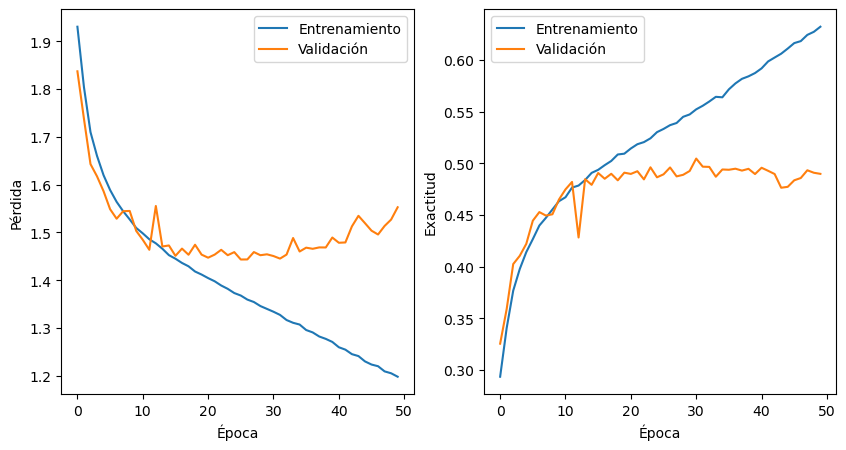

In [31]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

Finalmente, se verifica la exactitud en el conjunto de prueba.

In [32]:
mejor_convnext = mejor_resnet
total_pru = 0
acum_exact = 0.
for X_pru, y_pru in dataloader_pru:
    X_pru = X_pru.to(DC)
    y_pru = y_pru.to(DC)
    y_hat_pru = mejor_convnext(X_pru)
    total_pru += 1
    acum_exact += exactitud(y_hat_pru, y_pru)
exact_prom = acum_exact/total_pru
print("Exactitud en conjunto de prueba:\n", exact_prom)

Exactitud en conjunto de prueba:
 tensor(0.4376, device='cuda:0')


En las gráficas puede observarse que, al principio empieza a mejorar la exactitud, tanto en entrenamiento como en validación. Sin embargo, entre las épocas 10 y 20, la exactitud en el conjunto de validación se queda en una "meseta". Esto indica un sobreajuste de los datos en el conjunto de entrenamiento.

Puede observarse que la exactitud en el conjunto de prueba es de 43.76%, lo cual es cercano a la exactitud en el conjunto de validación en las últimas épocas.